### NOTE: The ground truth images are from the publicly available NYU Depth V2 dataset.

In [ ]:
!pip install --quiet torch torchvision

import torch #
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as pil
import cv2
import torchvision
from torchvision import transforms
import os #
import subprocess #
from typing import Optional
from typing import Tuple
import shutil
import sys
import torch.nn.functional as F
import logging
import warnings
import json

from PIL import Image
from sklearn.metrics import mean_absolute_error as mae
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# delete the old monodepth2 folder if it exists
if os.path.exists("monodepth2"):
    shutil.rmtree("monodepth2")  # remove the folder

# clone the repo again (only if it's missing)
!git clone https://github.com/nianticlabs/monodepth2.git

# move into monodepth2
os.chdir("monodepth2")
print("Current working directory:", os.getcwd())
"""
Depth Estimation Wrapper
This script wraps around the open-source Monodepth2 model (Niantic Labs, MIT License)
and adds custom preprocessing, stereo depth refinement, and integration with SuperGlue.
Author: [Your Name], 2025
"""
sys.path.append(os.getcwd()) #add to python path

Cloning into 'monodepth2'...
remote: Enumerating objects: 180, done.
remote: Total 180 (delta 0), reused 0 (delta 0), pack-reused 180 (from 1)
Receiving objects: 100% (180/180), 10.27 MiB | 13.62 MiB/s, done.
Resolving deltas: 100% (89/89), done.
Current working directory: /content/monodepth2


In [ ]:
"""
Depth Estimation Wrapper
This script wraps around the open-source Monodepth2 model (Niantic Labs, MIT License)
and adds custom preprocessing, stereo depth refinement, and integration with SuperGlue.
Author: FK, 2024
"""

from networks import ResnetEncoder, DepthDecoder # 1.2

class MonoDepthModel:  ##new version
    def __init__(self, model_path: str, device: str = 'cuda'):
        """Load and initialize MonoDepth2 model"""

        self.device = torch.device(device if torch.cuda.is_available() else "cpu")

        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model folder not found: {model_path}")

        encoder_path = os.path.join(model_path, "encoder.pth")
        decoder_path = os.path.join(model_path, "depth.pth") #

        if not os.path.exists(encoder_path) or not os.path.exists(decoder_path):
            raise FileNotFoundError("Model files missing! Ensure 'encoder.pth' and 'depth.pth' are in the model folder.")

        self.encoder = ResnetEncoder(num_layers=18, pretrained=False)
        self.decoder = DepthDecoder(num_ch_enc=self.encoder.num_ch_enc)

        encoder_state_dict = torch.load(encoder_path, map_location=self.device, weights_only=True)
        decoder_state_dict = torch.load(decoder_path, map_location=self.device, weights_only=True)

        for extra_key in ["height", "width", "use_stereo"]:
            encoder_state_dict.pop(extra_key, None)

        self.encoder.load_state_dict(encoder_state_dict, strict=False)
        self.decoder.load_state_dict(decoder_state_dict, strict=False)


        self.encoder.to(self.device).eval()
        self.decoder.to(self.device).eval()

    def preprocess_for_depth(self, image: np.ndarray) -> torch.Tensor:
        """Prepare image for depth estimation"""
        resize_image = torchvision.transforms.Resize((192, 640))
        format_change = torchvision.transforms.ToTensor()
        normalize_it = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        compose_all_transform = torchvision.transforms.Compose([resize_image, format_change, normalize_it])

        numpy_2_PIL_image = Image.fromarray(image)

        image_prepared = compose_all_transform(numpy_2_PIL_image).unsqueeze(0).to(self.device)

        return image_prepared

    @torch.no_grad()
    def estimate_depth(self, image: torch.Tensor) -> np.ndarray:
        """Generate depth map from image"""
        image_features = self.encoder(image)
        all_outputs = self.decoder(image_features)
        depth_map_extracted = all_outputs[("disp", 0)].squeeze().cpu().numpy()

        return depth_map_extracted

    def validate_depth(self,
                      depth_map: np.ndarray,
                      ground_truth: Optional[np.ndarray] = None) -> float:
        """Validate depth estimation quality"""

        if ground_truth is not None:
          mae_error = mae(ground_truth.flatten(), depth_map.flatten())
          return mae_error
        else:
          return None

    def spatial_loss_computation(self, depth_map: np.ndarray, superglue_map: np.ndarray) -> float:
        """Compute spatial loss (use depth map and superglue spatial map)"""

        #gradient difference
        depth_gradient_x, depth_gradient_y = np.gradient(depth_map) #how fast depth changes across the image
        spatial_gradient_x, spatial_gradient_y = np.gradient(superglue_map) #how fast spatial map changes across the image.

        #combine x ans y gradient into one
        depth_gradient = np.sqrt(depth_gradient_x**2 + depth_gradient_y**2)
        spatial_gradient = np.sqrt(spatial_gradient_x**2 + spatial_gradient_y**2)

        #spatial loss
        spatial_loss = np.mean(np.abs(depth_gradient - spatial_gradient))

        return spatial_loss

###################################

###

class DepthProcessor:
    def __init__(self, model: MonoDepthModel, calibration): #calibration: CameraCalibration
        """Setup depth processing pipeline"""
        self.model = model
        self.calibration = calibration

    def process_stereo_pair(self,
                           left_img: np.ndarray,
                           right_img: np.ndarray) -> np.ndarray:
        """Generate and refine depth from stereo pair"""
        left_image_preprocess = self.model.preprocess_for_depth(left_img)
        right_image_preprocess = self.model.preprocess_for_depth(right_img)

        left_depth_map = self.model.estimate_depth(left_image_preprocess)
        right_depth_map = self.model.estimate_depth(right_image_preprocess)

        merge_depth_map = (left_depth_map + right_depth_map) / 2

        return merge_depth_map

    def process_stereo_pair3(self,
                           left_img: np.ndarray,
                           right_img: np.ndarray,
                            center_img: np.ndarray) -> np.ndarray:
        """Generate and refine depth from stereo pair"""
        left_image_preprocess = self.model.preprocess_for_depth(left_img)
        right_image_preprocess = self.model.preprocess_for_depth(right_img)
        center_image_preprocess = self.model.preprocess_for_depth(center_img)

        left_depth_map = self.model.estimate_depth(left_image_preprocess)
        right_depth_map = self.model.estimate_depth(right_image_preprocess)
        center_depth_map = self.model.estimate_depth(center_image_preprocess)


        confidence_left = np.exp(-.5 * np.abs(left_depth_map - center_depth_map))
        confidence_right = np.exp(-.5 * np.abs(right_depth_map - center_depth_map))

        total_confidence = confidence_left + confidence_right + 1e-6

        merge_depth_map = (confidence_left * left_depth_map + confidence_right * right_depth_map + center_depth_map) / total_confidence

        return merge_depth_map


    def refine_depth_map(self, depth_map: np.ndarray) -> np.ndarray: #
        """Post-process and refine depth estimation"""

        noise_reduce = cv2.bilateralFilter(depth_map, d=9, sigmaColor=30, sigmaSpace=50)

        #kernel = np.ones((2, 2), np.uint8)
        #cleaned_depth = cv2.morphologyEx(noise_reduce, cv2.MORPH_OPEN, kernel)

        #smoothed_depth = cv2.GaussianBlur(cleaned_depth, (1, 1), 0)

        mask = (noise_reduce < 0.05).astype(np.uint8) #smoothed_depth < 0.05: use a threshold to avoid misclassifying low-depth values as missing.
        inpainted_depth_map = cv2.inpaint(noise_reduce, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

        refined_depth_map = inpainted_depth_map
        #refined_depth_map = cv2.filter2D(inpainted_depth_map, -1, kernel_sharp)

        return refined_depth_map
###

    def process_stereo_pair3_superglue(self, left_img: np.ndarray, right_img: np.ndarray,
                           center_img: np.ndarray, points3: np.ndarray, confidences: np.ndarray) -> Tuple[np.ndarray, float]:
        """Uses feature matches (spatial map) to adjust depth, after calculating depth for 3 cameras"""

        left_image_preprocess = self.model.preprocess_for_depth(left_img)
        right_image_preprocess = self.model.preprocess_for_depth(right_img)
        center_image_preprocess = self.model.preprocess_for_depth(center_img)

        left_depth_map = self.model.estimate_depth(left_image_preprocess)
        right_depth_map = self.model.estimate_depth(right_image_preprocess)
        center_depth_map = self.model.estimate_depth(center_image_preprocess)


        confidence_left = np.exp(-.5 * np.abs(left_depth_map - center_depth_map))
        confidence_right = np.exp(-.5 * np.abs(right_depth_map - center_depth_map))


        total_confidence = confidence_left + confidence_right + 1e-6

        merge_depth_map = (confidence_left * left_depth_map + confidence_right * right_depth_map + center_depth_map) / total_confidence

        #add in feature depth map
        feature_depth_map = make_feature_depth_map(points3, confidences, merge_depth_map)

        #
        spatial_loss = self.model.spatial_loss_computation(merge_depth_map, feature_depth_map)

        return merge_depth_map, feature_depth_map


###++++++++++

    def group_process_batch(self, left_img_folder, right_img_folder, center_img_folder,
                            points3_folder, confidences_folder):
      print(f"Received {len(locals())} arguments: {list(locals().keys())}")
      depth_map_all = []
      feature_depth_map_all = []

      for left_img, right_img, center_img, points3, confidences in zip(
          left_img_folder, right_img_folder, center_img_folder, points3_folder, confidences_folder):
        left_img = np.array(left_img, dtype=np.float32)
        right_img = np.array(right_img, dtype=np.float32)
        center_img = np.array(center_img, dtype=np.float32)

        depth_map, feature_map = self.process_stereo_pair3_superglue(left_img, right_img, center_img, points3, confidences)

        depth_map_all.append(depth_map)
        feature_depth_map_all.append(feature_map)

      return depth_map_all, feature_depth_map_all


    def check_depth_refine_ifNeed(self, depth_map_all: list, spatial_loss_all: list, superglue_map_folder: np.ndarray,
                                  error_threshold: float = .05, max_iteration: int = 6) -> np.ndarray:

        refined_depth_map_all_s = []
        superglue_map_list = list(superglue_map_folder)

        for depth_map, spatial_loss, superglue_map in zip(depth_map_all, spatial_loss_all, superglue_map_list):

          if spatial_loss < error_threshold:
            refined_depth_map_all_s.append(depth_map)
            continue #skip the while loop and move to the next depth map

          iteration_time = 0
          while iteration_time < max_iteration and spatial_loss > error_threshold:
            new_depth_map = self.refine_depth_map(depth_map) #refine it
            new_spatial_loss = self.model.spatial_loss_computation(depth_map, superglue_map)

            if new_spatial_loss < spatial_loss: #if the updated loss is smaller (or say less loss and we got improvement)
              depth_map = new_depth_map
              spatial_loss = new_spatial_loss
            else:
              break #stop refining if the loss doesn't improve

            iteration_time += 1

          refined_depth_map_all_s.append(depth_map)

        return refined_depth_map_all_s

#### ===

In [ ]:
def make_feature_depth_map(superglue_feature_map, merge_depth_map): # create feature depth map using matched feature points

      feature_depth_map = np.zeros_like(merge_depth_map)

      point3, confidences = superglue_feature_map

      for i in range(len(point3)):
        x, y = round(point3[i][0]), round(point3[i][1]) #each feature location for the center image, get it from point3 (its from center camera).
        if 0 <= x < merge_depth_map.shape[1] and 0 <= y < merge_depth_map.shape[0]:
          feature_depth_map[y, x] = (feature_depth_map[y, x] * confidences[i] + merge_depth_map[y, x]) / (confidences[i] + 1)

      return feature_depth_map

In [ ]:
def load_ground_truth(test_folder_path: str, num_images: int) -> list: #load the exact number of ground truth that we need.

    if not isinstance(test_folder_path, str):
        raise TypeError("test_folder_path must be a string representing the folder path.")
    if not isinstance(num_images, int):
        raise TypeError("num_images must be an integer.")


    if not os.path.exists(test_folder_path):
      raise FileNotFoundError(f"The Folder Doesn't Exist.")

    all_files = sorted(os.listdir(test_folder_path))

    depth_file = []
    for img in all_files:
      if img.endswith("_depth.png"):
        depth_file.append(img)

    if len(depth_file) >= num_images:
      depth_maps_selected = depth_file[:num_images]
    else:
      raise ValueError(f"We don't have enough depth map to be the ground truth.")

    depth_maps_stored_gt = []

    for file in depth_maps_selected:
        depth_map_path = os.path.join(test_folder_path, file)

        depth_map = cv2.imread(depth_map_path, cv2.IMREAD_UNCHANGED)
        depth_map = np.array(depth_map, dtype=np.float32) #NumPy array

        depth_maps_stored_gt.append(depth_map)

    return depth_maps_stored_gt

In [ ]:
# load images from ground truth

from google.colab import drive
drive.mount('/content/drive')

nyu2_test_folder = "file path" #a folder path for NYU Depth 2 folder. replace with actual file path when use

if os.path.exists(nyu2_test_folder):
    print("Folder found in Google Drive.")
else:
    print("Folder not found in Google Drive!")

print("\n")
depth_images_gt = [i for i in os.listdir(nyu2_test_folder) if i.endswith("_depth.png")]
print(f"Number of depth image within this folder: {len(depth_images_gt)}")

Mounted at /content/drive
Folder found in Google Drive.


Number of depth image within this folder: 654


In [ ]:
#different pre-trained model
models_path = "/content/drive/xxx/models"
models_path2 = "/content/drive/xxx/model_640x192" # mono+stereo_640x192

model_1024x320 = MonoDepthModel(model_path=models_path) #MonoDepth2 model
#model2 = MonoDepthModel(model_path=models_path2)

depth_processor = DepthProcessor(model=model_1024x320, calibration=None) #DepthProcessor

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### load images

In [ ]:
#load images from the 3 cameras
import os

from google.colab import drive
drive.mount('/content/drive')

center_img_folder = "/content/drive/xxx/24394836"
left_img_folder = "/content/drive/xxx/24394835"
right_img_folder = "/content/drive/xxx/24394830"

def see_if_file_exist(file_name):

  if os.path.exists(file_name):
      print("Folder found in Google Drive.")
      image_each = [i for i in os.listdir(file_name) if i.endswith(".png")]
      print(f"Number of depth image within this folder: {len(image_each)}")

  else:
      print("Folder not found in Google Drive! Need to Check!")


checkC = see_if_file_exist(center_img_folder)
see_if_file_exist(left_img_folder)
see_if_file_exist(right_img_folder)

def image_number_gtNall(center_img_folder, left_img_folder, right_img_folder):

  image_number_center = [i for i in os.listdir(center_img_folder) if i.endswith(".png")]
  image_number_left = [i for i in os.listdir(left_img_folder) if i.endswith(".png")]
  image_number_right = [i for i in os.listdir(right_img_folder) if i.endswith(".png")]


  if len(image_number_center) == len(image_number_left) == len(image_number_right):
    need_image_number = len(image_number_center)
  else:
    print("Inconsisitent image number!")
    need_image_number = min(len(image_number_center), len(image_number_left), len(image_number_right))

  return need_image_number


need_image_number = image_number_gtNall(center_img_folder, left_img_folder, right_img_folder)
print(f"Number of depth image needed for ground truth (and also for superglue): {need_image_number}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Folder found in Google Drive.
Number of depth image within this folder: 100
Folder found in Google Drive.
Number of depth image within this folder: 100
Folder found in Google Drive.
Number of depth image within this folder: 100
Number of depth image needed for ground truth (and also for superglue): 100


In [ ]:
# convert to NumPy array

def convert_2_array(file_path, img_number):

  converted_folder_A = []

  image_files = sorted([f for f in os.listdir(file_path) if f.endswith(('.png', '.jpg', '.tiff'))]) #get individual file names then append them into one file


  for i in range(img_number):
    img_file_1 = os.path.join(file_path, image_files[i]) #get complete paths for each individual image
    load_image_1 = cv2.imread(img_file_1, cv2.IMREAD_UNCHANGED) #load each individual image using the individual image path

    if load_image_1.dtype != np.uint8:
      load_image_1 = (load_image_1 * 255).astype(np.uint8)

    convert_array_each = np.array(load_image_1, dtype=np.uint8) #convert each loaded image into NumPy array
    converted_folder_A.append(convert_array_each) #append each NumPy array

  return converted_folder_A

center_img_folder = convert_2_array("/content/drive/xxx/24394836", need_image_number)


In [ ]:
# get ground truth
depth_maps_all_gt = load_ground_truth(nyu2_test_folder, need_image_number)

### Depth Estimation

In [ ]:
# depth estimation

def depth_estimation_only(left_img_folder, right_img_folder, center_img_folder, img_number):
  all_depth_maps = []

  for i in range(img_number):
    center_1 = center_img_folder[i]
    left_1 = left_img_folder[i]
    right_1 = right_img_folder[i]
    merge_depth_map_1 = depth_processor.process_stereo_pair3(left_img=left_1, right_img=right_1, center_img=center_1)
    all_depth_maps.append(merge_depth_map_1)

  return all_depth_maps

depth_map_no_feature = depth_estimation_only(left_img_folder, right_img_folder, center_img_folder, need_image_number)


In [ ]:
def resize_depth_maps(all_depth_map_file, depth_maps_all_gt):
  shape_size = depth_maps_all_gt[0].shape
  depth_map_resized = []

  for i in all_depth_map_file:
    i = cv2.resize(i, (shape_size[1], shape_size[0]), interpolation=cv2.INTER_NEAREST)
    depth_map_resized.append(i)

  return depth_map_resized

# Resize estimated depth maps to match ground truth
depth_map_no_featureR = resize_depth_maps(depth_map_no_feature, depth_maps_all_gt)

In [ ]:
#normalization: adjust the values to be within a fixed range (0 - 1) in order to be comparable.

def normalize_depth_maps_all(depth_map_all_kinds):
  maximum_value = np.max(depth_map_all_kinds)
  minimum_value = np.min(depth_map_all_kinds)
  return (depth_map_all_kinds - minimum_value) / (maximum_value - minimum_value)


#ground truth
depth_maps_all_gtN = normalize_depth_maps_all(depth_maps_all_gt)


In [ ]:
# validate depth using NYU Depth as ground truth

def validate_all_depth(all_depth_map_file, depth_maps_all_gt):
  mae_all = []
  for depth_map_1, gt_1 in zip(all_depth_map_file, depth_maps_all_gt):
    mae_1 = model_1024x320.validate_depth(depth_map_1, gt_1)
    mae_all.append(mae_1)

  return mae_all

validation_mae0 = validate_all_depth(depth_map_no_featureR, depth_maps_all_gtN)

# overall (average) MAE
overall_mae0 = np.mean(validation_mae0)


print(overall_mae0)

0.13152120441198348


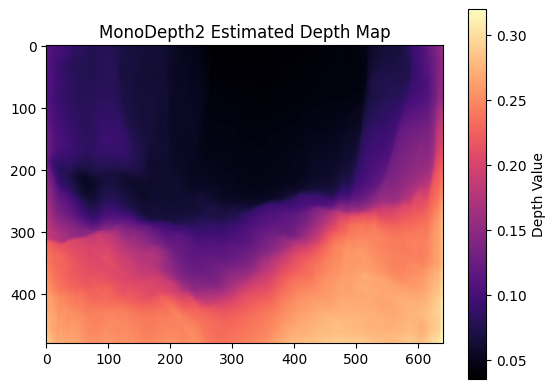

In [ ]:
def visualize_depth_map(depth_map):
    plt.imshow(depth_map, cmap="magma")  # try 'magma' or 'plasma' or 'viridis'
    plt.colorbar(label="Depth Value")
    plt.title("MonoDepth2 Estimated Depth Map")
    plt.show()

# visualize
visualize_depth_map(depth_map_no_featureR[0])

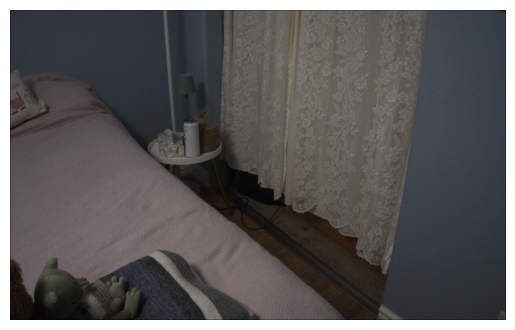

In [ ]:
def show_img(center_img_folder):

  image_number_center = [i for i in os.listdir(center_img_folder) if i.endswith(".png")]
  #image_number_left = [i for i in os.listdir(left_img_folder) if i.endswith(".png")]
  #image_number_right = [i for i in os.listdir(right_img_folder) if i.endswith(".png")]

  if image_number_center:
    first_image_path = os.path.join(center_img_folder, image_number_center[0])
    image = Image.open(first_image_path)

    # Display image
    plt.imshow(image)
    plt.axis('off')
    plt.show()
  else:
    print("No PNG images found in the specified folder.")

show_img("/content/drive/xxx/24394836")